### **Importing Libraries**

In [1]:
import torch
import math
import gc
import psutil
import time
import copy
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
import nltk
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from gensim.models import Word2Vec
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import string
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
    
## Task Specific Libraries
from transformers import AutoModelForCausalLM, AutoTokenizer, AdamW
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import BitsAndBytesConfig


[nltk_data] Downloading package punkt to /home/chetan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


cuda


2024-11-16 23:52:32.412923: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### **Loading Model**

In [2]:
model_name = "gpt2"

model_org = AutoModelForCausalLM.from_pretrained(
    "gpt2"
)

memory_footprint_bytes = model_org.get_memory_footprint()

memory_footprint_mb = memory_footprint_bytes / (1024 ** 2)
memory_footprint_gb = memory_footprint_bytes / (1024 ** 3)

print(f"Memory footprint: {memory_footprint_mb:.2f} MB")

Memory footprint: 486.70 MB


### **Quantization 8-bit Model**

In [3]:

quantization_config = BitsAndBytesConfig(
    load_in_8bit=True
    )

model_8bit = AutoModelForCausalLM.from_pretrained(
    "gpt2", 
    quantization_config=quantization_config,
    device_map="auto"
)

memory_footprint_bytes = model_8bit.get_memory_footprint()

memory_footprint_mb = memory_footprint_bytes / (1024 ** 2)
memory_footprint_gb = memory_footprint_bytes / (1024 ** 3)

print(f"Memory footprint: {memory_footprint_mb:.2f} MB")


Memory footprint: 168.35 MB


### **Quantization 4-Bit Model**

In [4]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="fp4",
    bnb_4bit_compute_dtype=torch.float16
    )

model_4bit = AutoModelForCausalLM.from_pretrained(
    "gpt2", 
    quantization_config=quantization_config,
    device_map="auto"
)

memory_footprint_bytes = model_4bit.get_memory_footprint()

memory_footprint_mb = memory_footprint_bytes / (1024 ** 2)
memory_footprint_gb = memory_footprint_bytes / (1024 ** 3)

print(f"Memory footprint: {memory_footprint_mb:.2f} MB")

Memory footprint: 127.85 MB


### **NF-4 Quantization Model**

In [5]:
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
)

model_nf4bit = AutoModelForCausalLM.from_pretrained(
    "gpt2", 
    quantization_config=nf4_config,
    device_map="auto"
)

memory_footprint_bytes = model_nf4bit.get_memory_footprint()

memory_footprint_mb = memory_footprint_bytes / (1024 ** 2)
memory_footprint_gb = memory_footprint_bytes / (1024 ** 3)

print(f"Memory footprint: {memory_footprint_mb:.2f} MB")

Memory footprint: 127.85 MB


### **Corpus Retrieval**

In [6]:
def retrieve_corpus(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        corpus = []
        for line in file:
            # print(line.strip().lower())
            corpus.append(line.lower())
        return corpus
    
def remove_punctuation(tokenized_sentence):
    return [word for word in tokenized_sentence if word not in string.punctuation]
    
# corpus_train = retrieve_corpus("./Dataset/ptb.train.txt")
# corpus_test = retrieve_corpus("./Dataset/ptb.test.txt")
# corpus_val = retrieve_corpus("./Dataset/ptb.valid.txt")

### **Loading Test Data**

In [7]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")

eval_texts = []
for item in dataset:
    if item['text'].strip():
        eval_texts.append(item['text'])
        if len(eval_texts) >= 3000:
            break
print(f"Loaded {len(eval_texts)} samples for evaluation")
test_data = eval_texts

Loaded 2891 samples for evaluation


### **Testing**

In [8]:
def compute_perplexity(model, tokenizer, dataset, max_length=1024, device='cpu'):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    loss_fn = nn.CrossEntropyLoss(reduction='sum')

    with torch.no_grad():
        for example in tqdm(dataset, desc="Calculating perplexity"):
            encodings = tokenizer(example, return_tensors='pt', truncation=True, padding=True, max_length=max_length)
            input_ids = encodings['input_ids'].to(device)
            attention_mask = encodings['attention_mask'].to(device)
            
            labels = input_ids.clone()
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            shift_logits = outputs.logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()

            loss = loss_fn(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            total_loss += loss.item()
            total_tokens += attention_mask.sum().item() - 1

        perplexity = math.exp(total_loss / total_tokens)

    return perplexity

def infer_text(model, tokenizer, prompt_text, max_length=50, device='cpu'):

    input_ids = tokenizer.encode(prompt_text, return_tensors='pt').to(device)
    generated_sequence = model.generate(
        input_ids=input_ids,
        max_length=max_length,
        do_sample=True,
        top_k=30,
        pad_token_id=tokenizer.eos_token_id,
        attention_mask=input_ids.new_ones(input_ids.shape)
    )
    return tokenizer.decode(generated_sequence[0], skip_special_tokens=True)

def measure_inference_time(model, tokenizer, prompt_text, device='cpu'):
    start = time.time()
    with torch.no_grad():
        infer_text(model, tokenizer, prompt_text, device=device)
    return time.time() - start

def evaluate_model(model,model_name="gpt2", dataset=None, device='cpu',quantized=False):

    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    if quantized is False:
        model.to(device) 

    perplexity_before = compute_perplexity(model, tokenizer, dataset, device=device)

    latency_before = measure_inference_time(model, tokenizer, dataset[0], device=device)
    
    
    return {
        "Latency": latency_before,
        "Perplexity": perplexity_before,
    }

In [9]:
results = evaluate_model(model_org,model_name="gpt2", dataset=test_data, device=device)
print("Original Model")
print(results)

results = evaluate_model(model_8bit,model_name="gpt2", dataset=test_data, device=device, quantized=True)
print("8 Bit Quantized Model")
print(results)

results = evaluate_model(model_4bit,model_name="gpt2", dataset=test_data, device=device, quantized=True)
print("4 Bit Quantized Model")
print(results)

results = evaluate_model(model_nf4bit,model_name="gpt2", dataset=test_data, device=device, quantized=True)
print("NF4 Quantized Model")
print(results)

Calculating perplexity: 100%|██████████| 2891/2891 [00:39<00:00, 72.66it/s] 


Original Model
{'Latency': 0.36611056327819824, 'Perplexity': 49.615657664681976}


Calculating perplexity: 100%|██████████| 2891/2891 [00:59<00:00, 48.27it/s]


8 Bit Quantized Model
{'Latency': 0.6902637481689453, 'Perplexity': 49.83906296567586}


Calculating perplexity: 100%|██████████| 2891/2891 [00:26<00:00, 109.38it/s]


4 Bit Quantized Model
{'Latency': 0.2402641773223877, 'Perplexity': 58.068903897044386}


Calculating perplexity:   0%|          | 0/2891 [00:00<?, ?it/s]/home/chetan/anaconda3/lib/python3.11/site-packages/bitsandbytes/nn/modules.py:452: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
Calculating perplexity: 100%|██████████| 2891/2891 [00:50<00:00, 56.93it/s]


NF4 Quantized Model
{'Latency': 0.2768716812133789, 'Perplexity': 53.2116608858351}


### **Plotting**

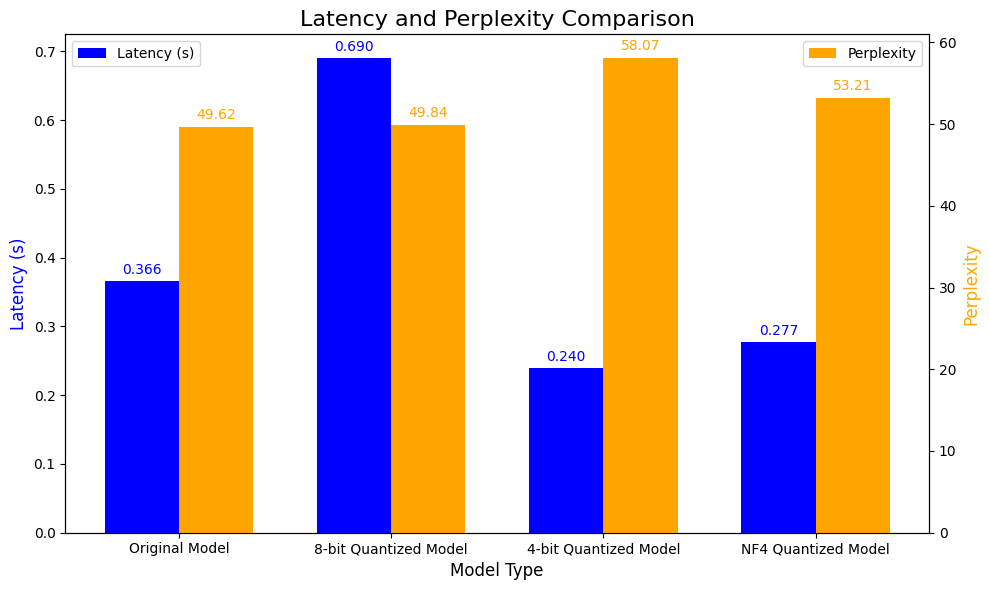

In [ ]:
model_types = [
    "Original GPT", 
    "8-bit Quantized", 
    "4-bit Quantized", 
    "4-bit NF Quantized"
]
memory_footprints = [486.70, 168.35, 127.85, 127.85]

plt.figure(figsize=(8, 6))
plt.bar(model_types, memory_footprints, color=["blue", "orange", "green", "red"])

plt.title("Memory Footprint Comparison", fontsize=16)
plt.xlabel("Model Type", fontsize=12)
plt.ylabel("Memory Footprint (MB)", fontsize=12)

for i, memory in enumerate(memory_footprints):
    plt.text(i, memory + 10, f"{memory:.2f} MB", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig("memory_part2.png")

models = [
    "Original Model",
    "8-bit Quantized Model",
    "4-bit Quantized Model",
    "NF4 Quantized Model"
]
latencies = [
    0.36611056327819824,
    0.6902637481689453,
    0.2402641773223877,
    0.2768716812133789
]
perplexities = [
    49.615657664681976,
    49.83906296567586,
    58.068903897044386,
    53.2116608858351
]

fig, ax1 = plt.subplots(figsize=(10, 6))

bar_width = 0.35
x = np.arange(len(models))

ax1.bar(x - bar_width / 2, latencies, bar_width, label="Latency (s)", color="blue")

ax2 = ax1.twinx()
ax2.bar(x + bar_width / 2, perplexities, bar_width, label="Perplexity", color="orange")

ax1.set_xlabel("Model Type", fontsize=12)
ax1.set_ylabel("Latency (s)", fontsize=12, color="blue")
ax2.set_ylabel("Perplexity", fontsize=12, color="orange")
ax1.set_title("Latency and Perplexity Comparison", fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(models)

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

for i, (lat, perp) in enumerate(zip(latencies, perplexities)):
    ax1.text(i - bar_width / 2, lat + 0.01, f"{lat:.3f}", ha="center", fontsize=10, color="blue")
    ax2.text(i + bar_width / 2, perp + 1, f"{perp:.2f}", ha="center", fontsize=10, color="orange")

plt.tight_layout()
plt.savefig("inference_part2.png")
